# Feature Engineering for Thalassemia Analysis

## Objectives
- Load cleaned Thalassemia data
- Create advanced clinical features
- Apply feature scaling and selection
- Validate feature importance
- Prepare optimized dataset for ML

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/nour/Desktop/thalassemia_predictor_v2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Cleaned Data

In [3]:
# Load cleaned data
df_cleaned = pd.read_csv('outputs/datasets/cleaned/thalassemia_cleaned.csv')
print(f"Cleaned dataset shape: {df_cleaned.shape}")
print(f"Features: {list(df_cleaned.columns)}")
print(f"\nClass distribution:")
print(df_cleaned['phenotype'].value_counts())

Cleaned dataset shape: (203, 12)
Features: ['sex', 'hb', 'pcv', 'rbc', 'mcv', 'mch', 'mchc', 'rdw', 'hba', 'hba2', 'hbf', 'phenotype']

Class distribution:
phenotype
alpha carrier    148
normal            55
Name: count, dtype: int64


## Enhanced Feature Engineering

In [5]:
# Create enhanced clinical features
df_eng = df_cleaned.copy()

# Basic clinical indicators
df_eng['mentzer_index'] = df_eng['mcv'] / df_eng['rbc']
df_eng['microcytosis'] = (df_eng['mcv'] < 80).astype(int)
df_eng['hypochromia'] = (df_eng['mch'] < 27).astype(int)
df_eng['hba2_elevated'] = (df_eng['hba2'] > 3.5).astype(int)
df_eng['rbc_hb_ratio'] = df_eng['rbc'] / df_eng['hb']

# Advanced clinical features
df_eng['anemia_severity'] = pd.cut(df_eng['hb'], 
                                  bins=[0, 8, 10, 12, 20], 
                                  labels=['severe', 'moderate', 'mild', 'normal']).astype(str)
df_eng['anemia_severity_encoded'] = pd.Categorical(df_eng['anemia_severity']).codes

# Hemoglobin pattern ratios
df_eng['hba2_hbf_ratio'] = df_eng['hba2'] / (df_eng['hbf'] + 0.1)  # Add small constant to avoid division by zero
df_eng['abnormal_hb_total'] = df_eng['hba2'] + df_eng['hbf']

# RBC morphology score (composite indicator)
df_eng['morphology_score'] = (df_eng['microcytosis'] + 
                             df_eng['hypochromia'] + 
                             (df_eng['mentzer_index'] < 13).astype(int))

# Thalassemia probability score (clinical heuristic)
df_eng['thal_prob_score'] = (
    df_eng['hba2_elevated'] * 3 +
    df_eng['microcytosis'] * 2 +
    df_eng['hypochromia'] * 2 +
    (df_eng['mentzer_index'] < 13).astype(int) * 2 +
    (df_eng['rbc'] > 5.0).astype(int) * 1
)

print(f"Enhanced dataset shape: {df_eng.shape}")
print(f"New features created: {df_eng.shape[1] - df_cleaned.shape[1]}")


Enhanced dataset shape: (203, 23)
New features created: 11


## Feature Selection and Importance

In [6]:
# Prepare features for selection
feature_cols = [col for col in df_eng.columns if col not in ['phenotype', 'anemia_severity']]
X = df_eng[feature_cols]
y = df_eng['phenotype']

# Handle any remaining missing values
X = X.fillna(X.median())

# Feature selection using multiple methods
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')

X_selected_f = selector_f.fit_transform(X, y)
X_selected_mi = selector_mi.fit_transform(X, y)

# Get feature scores
f_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': selector_f.scores_,
    'mi_score': selector_mi.scores_
})

f_scores['combined_score'] = f_scores['f_score'] + f_scores['mi_score']
f_scores = f_scores.sort_values('combined_score', ascending=False)

print("Top 10 features by combined score:")
print(f_scores.head(10))

Top 10 features by combined score:
                    feature   f_score  mi_score  combined_score
9                      hba2  3.720449  0.004111        3.724560
11            mentzer_index  3.098236  0.000000        3.098236
4                       mcv  3.007581  0.012692        3.020273
20          thal_prob_score  2.498358  0.014137        2.512495
13              hypochromia  2.217919  0.000000        2.217919
19         morphology_score  2.033642  0.042054        2.075696
17           hba2_hbf_ratio  1.883208  0.063230        1.946437
16  anemia_severity_encoded  1.634394  0.009648        1.644042
8                       hba  1.563202  0.004336        1.567538
5                       mch  1.442801  0.062993        1.505794


## Visualize Feature Importance

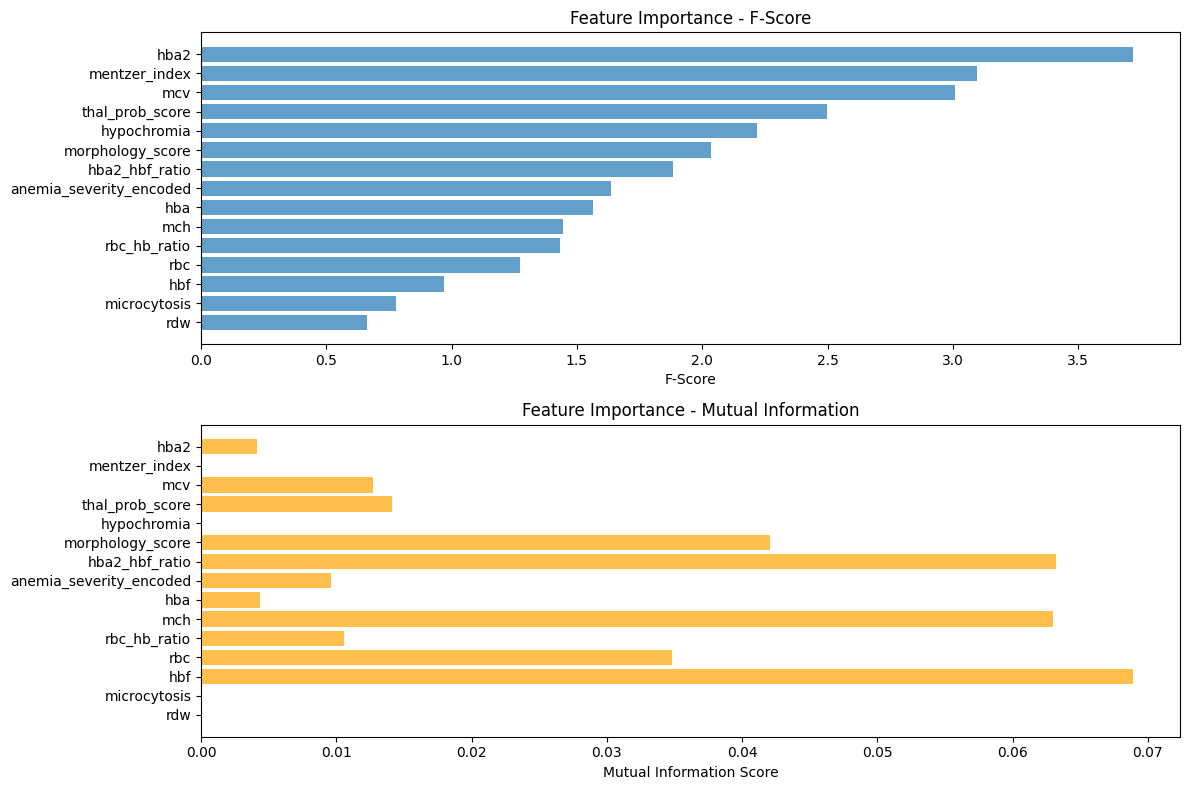

In [7]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = f_scores.head(15)

plt.subplot(2, 1, 1)
plt.barh(range(len(top_features)), top_features['f_score'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('F-Score')
plt.title('Feature Importance - F-Score')
plt.gca().invert_yaxis()

plt.subplot(2, 1, 2)
plt.barh(range(len(top_features)), top_features['mi_score'], alpha=0.7, color='orange')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance - Mutual Information')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/datasets/engineered/enhanced_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Select Top Features

In [8]:
# Select top features for modeling
top_k = 12  # Select top 12 features
selected_features = f_scores.head(top_k)['feature'].tolist()

print(f"Selected {len(selected_features)} features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Create final feature set
X_final = df_eng[selected_features]
y_final = df_eng['phenotype']

print(f"\nFinal feature set shape: {X_final.shape}")

Selected 12 features:
 1. hba2
 2. mentzer_index
 3. mcv
 4. thal_prob_score
 5. hypochromia
 6. morphology_score
 7. hba2_hbf_ratio
 8. anemia_severity_encoded
 9. hba
10. mch
11. rbc_hb_ratio
12. rbc

Final feature set shape: (203, 12)


## Train-Test Split

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_final
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

Training set: (162, 12)
Test set: (41, 12)

Training class distribution:
phenotype
alpha carrier    118
normal            44
Name: count, dtype: int64

Test class distribution:
phenotype
alpha carrier    30
normal           11
Name: count, dtype: int64


## Save Enhanced Features

In [10]:
# Create enhanced directory
import os
enhanced_dir = 'outputs/datasets/enhanced'
os.makedirs(enhanced_dir, exist_ok=True)

# Save datasets
X_train.to_csv(f'{enhanced_dir}/X_train_enhanced.csv', index=False)
X_test.to_csv(f'{enhanced_dir}/X_test_enhanced.csv', index=False)
y_train.to_csv(f'{enhanced_dir}/y_train_enhanced.csv', index=False)
y_test.to_csv(f'{enhanced_dir}/y_test_enhanced.csv', index=False)

# Save feature importance
f_scores.to_csv(f'{enhanced_dir}/feature_importance_enhanced.csv', index=False)

# Save selected features list
with open(f'{enhanced_dir}/selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")

print(f"Enhanced features saved to: {enhanced_dir}")
print(f"Selected features: {len(selected_features)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Enhanced features saved to: outputs/datasets/enhanced
Selected features: 12
Training samples: 162
Test samples: 41
